In [1]:
# Standard imports
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
plt.rcParams.update({'font.size': 15})

# Import Photochem
from photochem import EvoAtmosphere, PhotoException

# Problem: Simulate the Archean Earth Atmosphere

Create a model of the Archean Earth atmosphere (~3 billion years ago) to answer the following questions:

1. If the Archean Earth surface biological CH$_4$ flux was the same as today ($10^{11}$ molecule/cm$^2$/s), then what was the surface CH$_4$ concentration?
2. What was the main destruction path for CH$_4$ in the Archean?
3. What was the surface O$_2$ concentration in the Archean?

# Directions

Follow these directions to solve the above problem.

1. Open up the `settings.yaml` file in this directory, and fill in boundary conditions for N$_2$, CO$_2$ and CH$_4$ appropriate for the Archean Eon.
2. In the code cell below, fill in an assumed surface temperature and eddy diffusion coefficient (vertically constant) for the Archean.
3. Run the code cell bellow. By using `input_files.py`, this code will create the remaining inputs needed for the photochemical model: (1) a reactions file, (2) a stellar flux file and (3) the file "atmosphere_init.txt" which contains a temperature and $K_{zz}$ profile and an initial guess for the atmosphere's composition. The code will also initialize the photochemical model with these generated files.
4. Integrate the photochemical model to a steady-state. In a cell below, I provide the `find_steady_state` function, for accomplishing this.
5. Use the steady-state photochemical model to answer the questions above.

In [2]:
### SELECT A SURFACE TEMPERATURE AND KZZ VALUE

T_surf = 288.0 # Surface temperature
Kzz = 1e6 # The eddy diffusion (vertically constant, cm^2/s)

###

# Import input_files.py
import input_files

# Creates a chemical reaction network with H, N, O, C species
input_files.create_zahnle_HNOC()

# Creates a spectrum of the Sun at 3.5 Ga
input_files.create_Sun_35Ga()

# Creates a T, Kzz, and initial gas concentration profiles
input_files.create_atmosphere_init(
    setting_file='COMPLETED/settings_COMPLETED.yaml', 
    T_surf=T_surf,
    Kzz=T_surf #
)

# Initialize the code
pc = EvoAtmosphere(
    'zahnle_HNOC.yaml',
    'COMPLETED/settings_COMPLETED.yaml',
    'Sun_3.5Ga.txt',
    'atmosphere_init.txt'
)
pc.var.verbose = 0
pc.var.atol = 1e-20
pc.var.autodiff = True

In [3]:
def plot_atmosphere(pc, species = ['H2O','N2','O2','CO2','O3','CH4']):
    "Creates a plot of the atmosphere"
    
    # Creates plot
    fig,ax = plt.subplots(1,1,figsize=[6,5])
    
    # This function returns the state of the atmosphere in dictionary
    sol = pc.mole_fraction_dict()

    # Plots species
    for i,sp in enumerate(species):
        ax.plot(sol[sp], sol['pressure']/1e6, label=sp)

    # default settings
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.invert_yaxis()
    ax.grid(alpha=0.4)
    ax.set_xlim(1e-10,1)
    ax.set_ylabel('Pressure (bars)')
    ax.set_xlabel('Mixing ratio')
    ax.legend(ncol=1,bbox_to_anchor=(1,1.0),loc='upper left')
    ax.text(0.02, 1.04, 't = '+'%e s'%pc.wrk.tn, \
        size = 15,ha='left', va='bottom',transform=ax.transAxes)
    
    return fig, ax

def find_steady_state(pc, plot=True, plot_species=['H2O','N2','O2','CO2','CH4','CO','H2'], plot_freq=50, xlim=(1e-10,1)):
    "Integrates the model to a steady state."
    
    pc.initialize_stepper(pc.wrk.usol) 
    converged = False
    nsteps = 0
    nerrors = 0
    while not converged:
        if plot:
            clear_output(wait=True)
            fig,ax = plot_atmosphere(pc, plot_species)
            ax.set_xlim(*xlim)
            plt.show()
        for i in range(plot_freq):
            try:
                tn = pc.step()
            except PhotoException as e:
                pc.initialize_stepper(np.clip(pc.wrk.usol,a_min=1e-40,a_max=np.inf))
                nerrors += 1
                if nerrors > 10:
                    raise PhotoException(e)
            nsteps += 1
            converged = pc.check_for_convergence()
            if converged:
                break
            if nsteps > 1000:
                pc.initialize_stepper(np.clip(pc.wrk.usol,a_min=1e-40,a_max=np.inf))
                nsteps = 0
    pc.destroy_stepper()

Compute a steady-state atmosphere

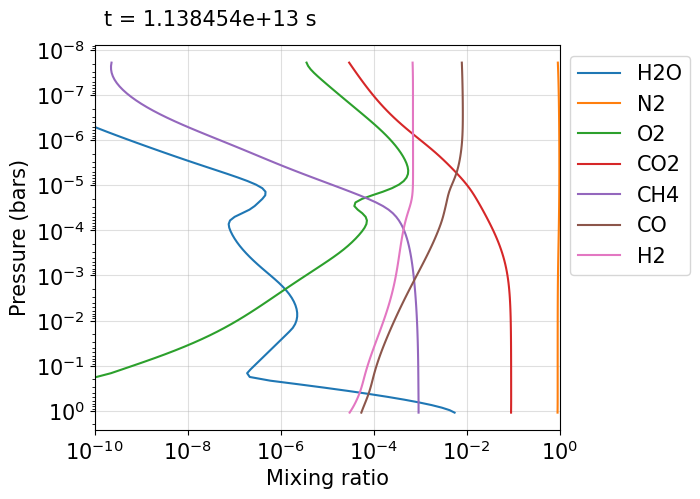

In [4]:
find_steady_state(
    pc, 
    plot_species=['H2O','N2','O2','CO2','CH4','CO','H2'],
    xlim=(1e-10,1)
)

> 1. If the Archean Earth surface biological CH$_4$ flux was the same as today ($10^{11}$ molecule/cm$^2$/s), then what was the surface CH$_4$ concentration?

In [5]:
sol = pc.mole_fraction_dict()
print('%e'%sol['CH4'][0])

9.265517e-04


> 2. What was the main destruction path for CH$_4$ in the Archean?

In [6]:
pl = pc.production_and_loss('CH4',pc.wrk.usol)
for i in range(5):
    print('{:30}'.format(pl.loss_rx[i])+'%e'%pl.integrated_loss[i])

CH4 + O => CH3 + OH           1.162683e+11
CH4 + OH => CH3 + H2O         5.033272e+10
CH4 + hv => 1CH2 + H2         1.676803e+09
CH4 + hv => CH3 + H           1.637959e+09
CH4 + hv => CH2 + H + H       8.430878e+08


> 3. What was the surface O$_2$ concentration in the Archean?

In [7]:
sol = pc.mole_fraction_dict()
print('%e'%sol['O2'][0])

1.359202e-19
